## 文本分类

### 导入库

In [1]:
import torchtext
from torchtext.datasets import AG_NEWS
import torch
import torch.nn as nn  
import matplotlib.pyplot as plt  
from tqdm import tqdm  
import numpy as np   

/home/wangxv/Files/course/dl/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 下载数据集以及统计数据集的形式  

In [2]:
#下载数据集
train_data = AG_NEWS(split='train')
test_data = AG_NEWS(split='test')
for i in train_data:#看一下训练数据的结构
    print(i)
    break
#这里可以看出结构就是(class,text)
classes=[i[0] for i in train_data]
classes=list(set(classes))
print(classes)
class_num=len(classes)
#这里看出一共是四个类
num=0
text=""
for i in train_data:
    num+=1  
    text+=i[1]
average_length=len(text)/num  
print(average_length)
#这里可以得到平均长度(这里是字符串长度)

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
[1, 2, 3, 4]
236.477525


### 利用torchtext内置的工具进行文本预处理  

- 先定义一些文本处理工具

In [3]:
from torchtext.data.utils import get_tokenizer  
from torchtext.vocab import build_vocab_from_iterator  
#拿到分词器    
tokenizer = get_tokenizer('basic_english')  
#这里计算一下text的单词平均长度
length=0  
num=0  
for i in train_data:
    num+=1
    length+=len(tokenizer(i[1]))
print(length//num)
avg_len=length//num  
#创建词汇表  
vocabulary=build_vocab_from_iterator(map(lambda x:tokenizer(x[1]),train_data),specials=["|NONE|"])
vocabulary.set_default_index(vocabulary["|NONE|"])#设置未出现单词的默认索引  

43


- 定义loader
> 这里还需要进行预处理，即把对应的文本转换为对应索引列表

In [4]:
import torch.utils
import torch.utils.data
def preprocess(batch):#这里按批次处理数据  
    labels,texts=zip(*batch)
    labels=torch.tensor(labels)
    tokens=[]
    #这里要统一text长度，我是按照平均长度  
    for text in texts:
        #获取text长度
        l=len(tokenizer(text))
        add_l=avg_len-l  
        tmp=vocabulary(tokenizer(text))[:avg_len]  
        tmp+=[vocabulary["|NONE|"] for i in range(0,add_l)]
        tokens.append(tmp)
    tokens=torch.Tensor(tokens)
    return labels,tokens    
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, collate_fn=preprocess)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, collate_fn=preprocess)

### 定义评测函数  

In [5]:
def evaluate(model,loader):
    model.eval()
    right_num=0
    total_num=0
    for label,data in loader:
        outputs=model(data)
        outputs=outputs.reshape(-1,).detach().numpy().tolist()
        labels=label.reshape(-1,).detach().numpy().tolist()
        for i in range(len(labels)):
            total_num+=1
            if(labels[i]==outputs[i]):
                right_num+=1
    return right_num/total_num  

### 定义训练流程

In [6]:
def train(title,model,train_loader,test_loader,criterion,optimizer,epoch_num):
    loss_list=[]
    acc_list=[]
    print("Train {}".format(title))
    for epoch in range(epoch_num):
        model.train()
        tmp_loss=[]
        num=0
        for labels, texts in tqdm(train_loader):
            num+=1
            if(num>=50):
                break
            optimizer.zero_grad()
            outputs = model(texts)
            labels-=1#这里有坑因为给的标签是从1开始的
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            tmp_loss.append(float(loss))
        #获取这一轮的平均损失
        loss_list.append(sum(tmp_loss)/len(tmp_loss))
        #获取这一轮的在验证集上正确率
        acc_list.append(evaluate(model,test_loader))
    plt.plot(np.linspace(0,len(loss_list)+1,len(loss_list)),loss_list,c='r')
    plt.title(title)
    plt.show()
    plt.plot(np.linspace(0,len(acc_list)+1,len(acc_list)),acc_list,c='g')  
    plt.title(title)
    plt.show()  

### 基于全连接的模型

In [7]:
class FCModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, class_num):
        super(FCModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, class_num)
    def forward(self, x):
        x=x.long()
        x = self.embedding(x)
        x = x.mean(dim=1)  #使用平均池化
        x = self.fc(x)
        return x
fc_model = FCModel(len(vocabulary), 100, class_num)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_model.parameters())
#train("fc model",fc_model,train_loader,test_loader,criterion,optimizer,10)

### 基于CNN的模型

In [8]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, class_num):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)#这里我们把每一个句子看成avg_num*embed_dim*1的图片就好理解了  
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=64,kernel_size=2,stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu=nn.ReLU()
        self.fc = nn.Linear(3840, class_num)
    def forward(self, x):
        x=x.long()
        x = self.embedding(x).unsqueeze(1)#添加通道维度
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0),-1)  
        x = self.fc(x)
        return x
cnn_model = CNNModel(len(vocabulary), 100, class_num)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters())
#train("cnn model",cnn_model,train_loader,test_loader,criterion,optimizer,10)

### 基于RNN的模型分类(双向)

In [9]:
class RNNModel(nn.Module):
    def __init__(self,vocab_size,embed_dim,class_num):
        super(RNNModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn=nn.RNN(input_size=100,hidden_size=64,num_layers=2,bidirectional=True,batch_first=True)
        self.fc=nn.Linear(64*2,class_num)
    def forward(self,x):
        x=x.long()
        x=self.embedding(x)
        out,_=self.rnn(x)
        out=out[:,-1,:]
        out=self.fc(out)
        return out  
rnn_model = RNNModel(len(vocabulary), 100, class_num)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters())
#train("rnn model",rnn_model,train_loader,test_loader,criterion,optimizer,5)

### 基于Transformer  编码解码结构 的模型分类

Train transformer model


49it [00:20,  2.35it/s]
49it [00:21,  2.33it/s]
49it [00:20,  2.34it/s]
49it [00:20,  2.37it/s]
49it [00:20,  2.36it/s]


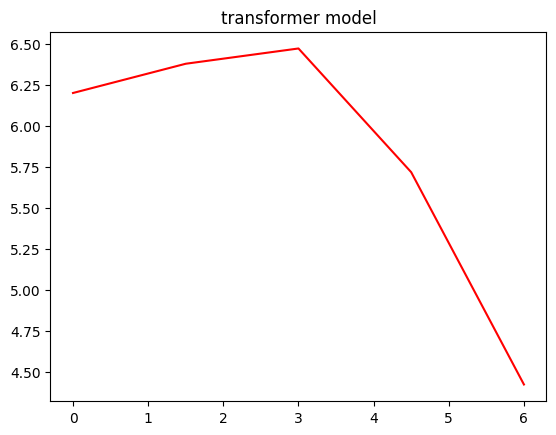

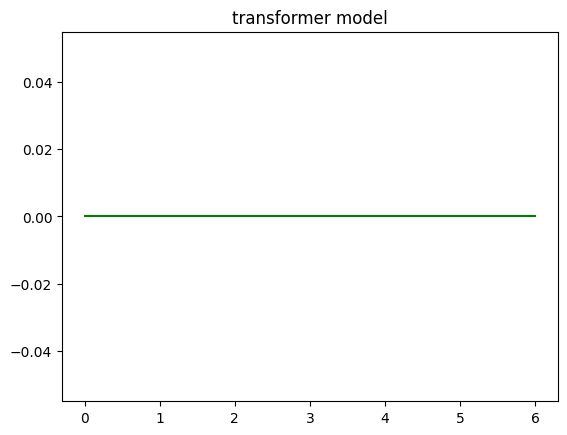

In [14]:
import torch
import torch.nn as nn
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, class_num):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = nn.Transformer(d_model=embed_dim, 
                                          nhead=2,
                                           num_encoder_layers=1, 
                                           num_decoder_layers=1)
        self.model_dim=embed_dim
        self.fc = nn.Linear(embed_dim*100, class_num)
    def forward(self, x):
        x=x.long()
        x=self.embedding(x)
        src = x.reshape(x.shape[1],x.shape[0],-1)
        tgt = torch.zeros(( 100, x.shape[0],self.model_dim))
        out = self.transformer(src, tgt)
        out = out.reshape(out.shape[1],-1)
        out = self.fc(out)
        return out
ts_model = TransformerModel(len(vocabulary), 100, class_num)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ts_model.parameters())
train("transformer model",ts_model,train_loader,test_loader,criterion,optimizer,5)